In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install efficientnet_pytorch

In [ ]:
pip install torch_geometric

In [ ]:
import numpy as np
import cv2
import glob
import pandas as pd
import os
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf

In [ ]:
import zipfile
import os

# Path to the uploaded ZIP file
zip_file_path = "/content/drive/MyDrive/DR_fundus_dataset.zip"
extracted_path = "fundus_image"

# Extract the ZIP file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_path)

print(f"Dataset extracted to {extracted_path}")

Dataset extracted to fundus_image


In [ ]:
file_path = '/content/fundus_image/DR_fundus_dataset/merged_labels.csv'
df = pd.read_csv(file_path)

In [ ]:
folder_path = '/content/fundus_image/DR_fundus_dataset/train_images'
image_pattern = '*.png'
image_files = glob.glob(os.path.join(folder_path, image_pattern))

(2136, 3216, 3)


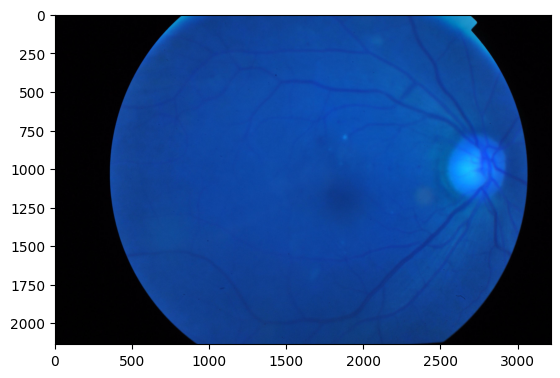

In [ ]:
img = cv2.imread('/content/fundus_image/DR_fundus_dataset/train_images/1ae8c165fd53.png')
print(img.shape)
plt.imshow(img)

In [ ]:
data = []
labels = []

image_size=(128,128)
for index, row in df.iterrows():
    image_path = f"/content/fundus_image/DR_fundus_dataset/train_images/{row['id_code']}.png"
    image = cv2.imread(image_path)
    image = cv2.resize(image, image_size)
    data.append(image)
    labels.append(row['diagnosis'])

In [ ]:
X_train = np.array(data)
X_train = (X_train - np.min(X_train)) / (np.max(X_train) - np.min(X_train))
y_train = np.array(labels, dtype=np.int32)

print(X_train.shape)
print(y_train.shape)

(3662, 128, 128, 3)
(3662,)


In [ ]:
print(y_train)

[2 1 4 ... 2 0 2]


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from efficientnet_pytorch import EfficientNet
from torch_geometric.nn import GATConv
from sklearn.model_selection import train_test_split
import numpy as np

In [ ]:
X_train = np.array(data)
y_train = np.array(labels, dtype=np.int32)

X_train, X_temp, y_train, y_temp = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train, random_state=42)  # Adjust test_size as needed
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

In [ ]:
class DiabeticRetinopathyDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        # Convert image to PyTorch tensor
        image = torch.tensor(image, dtype=torch.float).permute(2, 0, 1) / 255.0  # Normalize to [0, 1]
        label = torch.tensor(label, dtype=torch.long)

        return image, label

In [ ]:
train_dataset = DiabeticRetinopathyDataset(X_train, y_train)
val_dataset = DiabeticRetinopathyDataset(X_val, y_val)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [ ]:
class EfficientNetGCN(nn.Module):
    def __init__(self, num_classes, gat_hidden_dim=128):
        super(EfficientNetGCN, self).__init__()

        # EfficientNet Backbone
        self.efficient_net = EfficientNet.from_pretrained('efficientnet-b0')
        self.efficient_net._fc = nn.Identity()  # Remove the final classification layer

        # Graph Attention Network (GAT) Layers
        self.gat1 = GATConv(1280, gat_hidden_dim, heads=4, concat=True)
        self.gat2 = GATConv(gat_hidden_dim * 4, gat_hidden_dim, heads=4, concat=True)

        # Classification Head
        self.fc = nn.Sequential(
            nn.Linear(gat_hidden_dim * 4, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )

    def forward(self, x, edge_index):
        # Feature Extraction
        features = self.efficient_net.extract_features(x)  # Shape: [batch_size, 1280, height, width]

        # Flatten the feature map
        batch_size, feature_dim, height, width = features.size()
        features = features.view(batch_size, feature_dim, -1).permute(0, 2, 1)  # Shape: [batch_size, num_nodes, feature_dim]
        features = features.reshape(-1, feature_dim)  # Shape: [batch_size * num_nodes, feature_dim]

        # Create new edge_index for the flattened graph
        num_nodes = height * width
        batch_edge_index = []
        for batch in range(batch_size):
            base_idx = batch * num_nodes
            edges = torch.combinations(torch.arange(num_nodes), r=2).t() + base_idx
            batch_edge_index.append(edges)
        edge_index = torch.cat(batch_edge_index, dim=1).to(features.device)

        # GAT Layers
        x = self.gat1(features, edge_index)
        x = self.gat2(x, edge_index)

        # Classification
        x = x.view(batch_size, -1, x.size(1)).mean(dim=1)  # Global pooling over nodes
        out = self.fc(x)
        return out

In [ ]:
def train_model(model, train_loader, val_loader, num_epochs=10, learning_rate=1e-4):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images, None)  # No edge_index needed as it's created inside the model
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        train_accuracy = correct / total
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader):.4f}, Train Accuracy: {train_accuracy:.4f}")

        # Validation
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images, None)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, preds = torch.max(outputs, 1)
                val_correct += (preds == labels).sum().item()
                val_total += labels.size(0)

        val_accuracy = val_correct / val_total
        print(f"Validation Loss: {val_loss/len(val_loader):.4f}, Validation Accuracy: {val_accuracy:.4f}")

In [ ]:
num_classes = len(np.unique(y_train))
model = EfficientNetGCN(num_classes=num_classes)
train_model(model, train_loader, val_loader, num_epochs=50)

Loaded pretrained weights for efficientnet-b0
Epoch 1/50, Loss: 0.9423, Train Accuracy: 0.6432
Validation Loss: 1.2798, Validation Accuracy: 0.4918
Epoch 2/50, Loss: 0.6228, Train Accuracy: 0.7586
Validation Loss: 1.1074, Validation Accuracy: 0.5519
Epoch 3/50, Loss: 0.4878, Train Accuracy: 0.8170
Validation Loss: 0.8802, Validation Accuracy: 0.6639
Epoch 4/50, Loss: 0.3936, Train Accuracy: 0.8515
Validation Loss: 0.7057, Validation Accuracy: 0.7268
Epoch 5/50, Loss: 0.2905, Train Accuracy: 0.8860
Validation Loss: 0.7691, Validation Accuracy: 0.7514
Epoch 6/50, Loss: 0.2352, Train Accuracy: 0.9164
Validation Loss: 0.8365, Validation Accuracy: 0.7678
Epoch 7/50, Loss: 0.1888, Train Accuracy: 0.9307
Validation Loss: 0.8592, Validation Accuracy: 0.7705
Epoch 8/50, Loss: 0.1526, Train Accuracy: 0.9447
Validation Loss: 0.9446, Validation Accuracy: 0.7678
Epoch 9/50, Loss: 0.1215, Train Accuracy: 0.9577
Validation Loss: 0.9243, Validation Accuracy: 0.7787
Epoch 10/50, Loss: 0.1129, Train Acc

In [ ]:
print(len(train_dataset))
print(len(val_dataset))

2929
366


In [ ]:
class TestDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        image = torch.tensor(image, dtype=torch.float).permute(2, 0, 1) / 255.0
        label = torch.tensor(label, dtype=torch.long)

        return image, label

In [ ]:
test_dataset = TestDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [ ]:
print(len(test_dataset))

367


Accuracy: 0.7820

Classification Report:
              precision    recall  f1-score   support

     Class 0       0.95      0.96      0.95       181
     Class 1       0.58      0.49      0.53        37
     Class 2       0.67      0.78      0.72       100
     Class 3       0.45      0.26      0.33        19
     Class 4       0.48      0.40      0.44        30

    accuracy                           0.78       367
   macro avg       0.63      0.58      0.59       367
weighted avg       0.77      0.78      0.77       367



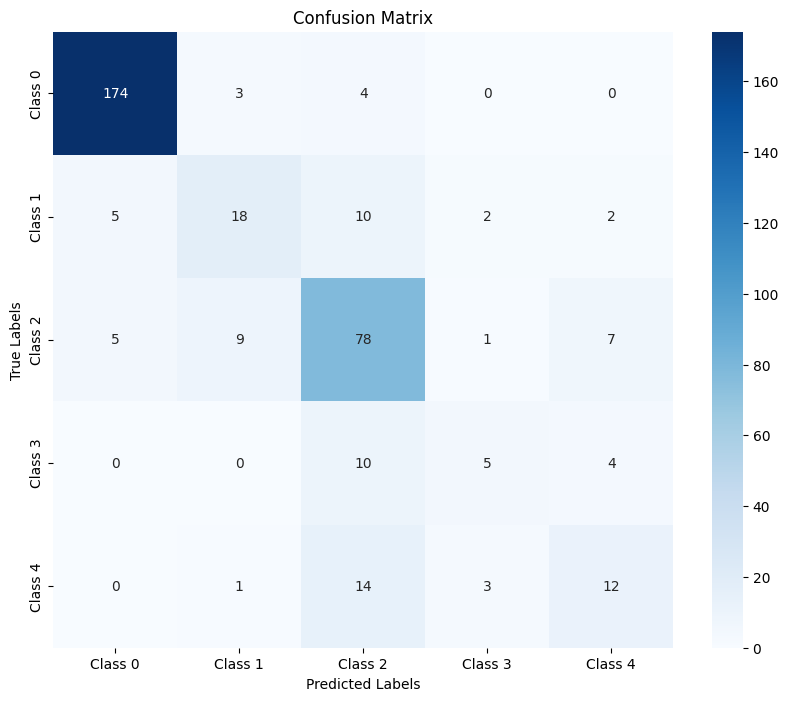

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import torch

def test_model_with_metrics(model, test_loader):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    model.eval()

    # Storage for true labels and predictions
    all_labels = []
    all_preds = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images, None)  # Edge index is handled inside the model
            _, preds = torch.max(outputs, 1)

            # Store labels and predictions
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())

    # Calculate metrics
    accuracy = (np.array(all_labels) == np.array(all_preds)).mean()
    report = classification_report(all_labels, all_preds, target_names=[f"Class {i}" for i in range(len(set(all_labels)))])
    cm = confusion_matrix(all_labels, all_preds)

    # Print results
    print(f"Accuracy: {accuracy:.4f}")
    print("\nClassification Report:")
    print(report)

    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[f"Class {i}" for i in range(len(set(all_labels)))], yticklabels=[f"Class {i}" for i in range(len(set(all_labels)))])
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title("Confusion Matrix")
    plt.show()

    return accuracy, report, cm

# Run the test function
test_accuracy, test_report, test_cm = test_model_with_metrics(model, test_loader)


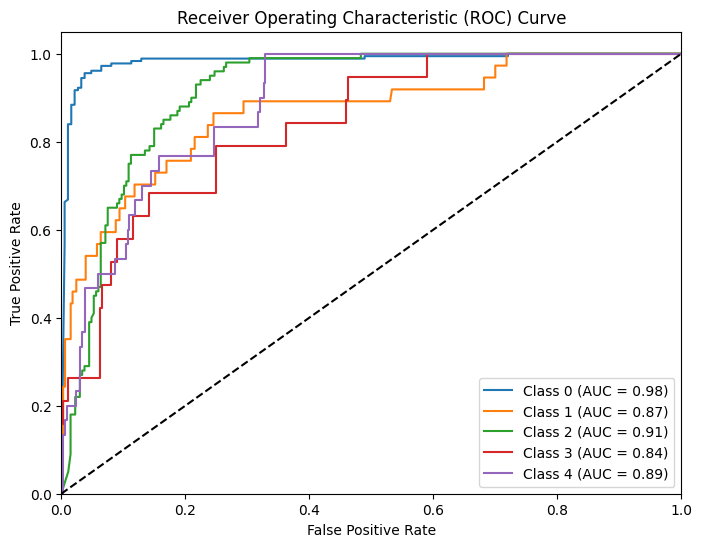

In [ ]:
# prompt: auc and roc

from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

def test_model_with_roc(model, test_loader):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    model.eval()

    all_labels = []
    all_probs = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images, None)
            probs = torch.softmax(outputs, dim=1)
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    # Calculate ROC curve and AUC for each class
    num_classes = len(set(all_labels))
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(num_classes):
        binary_labels = [1 if label == i else 0 for label in all_labels]
        binary_probs = [prob[i] for prob in all_probs]
        fpr[i], tpr[i], _ = roc_curve(binary_labels, binary_probs)
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Plot ROC curve for each class
    plt.figure(figsize=(8, 6))
    for i in range(num_classes):
        plt.plot(fpr[i], tpr[i], label=f"Class {i} (AUC = {roc_auc[i]:.2f})")

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

# Call the function to generate ROC curves
test_model_with_roc(model, test_loader)